In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import os
import cv2
from PIL import Image
import plotly.express as px
import plotly.graph_objects as go
from skimage.feature.texture import graycomatrix, graycoprops
from skimage.measure import label, regionprops
from skimage.measure import moments_hu
from tqdm import tqdm
from sklearn.cluster import DBSCAN
from scipy.stats import spearmanr
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from collections import defaultdict
import shutil
import hashlib

Définitions des fonctions statistiques et graphiques des caractéristiques

In [2]:
df = pd.read_csv("/workspaces/datasciencetest_reco_plante/notebooks/Plant_V_Seg_all_features.csv")
df.head()

,ID_Image,Est_Saine,is_black,dimensions,aire,périmètre,circularité,excentricité,aspect_ratio,mean_R,...,disease_Leaf_blight_(Isariopsis_Leaf_Spot),disease_Leaf_scorch,disease_Northern_Leaf_Blight,disease_Powdery_mildew,disease_Septoria_leaf_spot,disease_Spider_mites Two-spotted_spider_mite,disease_Target_Spot,disease_Tomato_Yellow_Leaf_Curl_Virus,disease_Tomato_mosaic_virus,disease_healthy
0,1,0,0,27x53,549.5,224.208151,0.137365,0.908846,0.509434,0.051777,...,False,False,False,False,False,False,False,False,True,False
1,2,0,0,115x94,2425.0,1143.082383,0.023322,0.860274,1.223404,0.084200,...,False,False,False,False,False,False,False,False,True,False
2,3,0,0,73x78,1662.0,807.092487,0.032062,0.841733,0.935897,0.057895,...,False,False,False,False,False,False,False,False,True,False
3,4,0,0,142x170,8371.5,2032.642906,0.025462,0.710637,0.835294,0.107897,...,False,False,False,False,False,False,False,False,True,False
4,5,0,0,31x31,247.5,155.296463,0.128962,0.934820,1.000000,0.070700,...,False,False,False,False,False,False,False,False,True,False


In [3]:
df.columns

Index(['ID_Image', 'Est_Saine', 'is_black', 'dimensions', 'aire', 'périmètre',
       'circularité', 'excentricité', 'aspect_ratio', 'mean_R', 'mean_G',
       'mean_B', 'std_R', 'std_G', 'std_B', 'contrast', 'energy',
       'homogeneity', 'dissimilarite', 'Correlation', 'contour_density',
       'mean_H', 'mean_S', 'mean_V', 'netteté', 'hu_1', 'hu_2', 'hu_3', 'hu_4',
       'hu_5', 'hu_6', 'hu_7', 'plant_Apple', 'plant_Blueberry',
       'plant_Cherry_(including_sour)', 'plant_Corn_(maize)', 'plant_Grape',
       'plant_Orange', 'plant_Peach', 'plant_Pepper,_bell', 'plant_Potato',
       'plant_Raspberry', 'plant_Soybean', 'plant_Squash', 'plant_Strawberry',
       'plant_Tomato', 'disease_Apple_scab', 'disease_Bacterial_spot',
       'disease_Black_rot', 'disease_Cedar_apple_rust',
       'disease_Cercospora_leaf_spot Gray_leaf_spot', 'disease_Common_rust_',
       'disease_Early_blight', 'disease_Esca_(Black_Measles)',
       'disease_Haunglongbing_(Citrus_greening)', 'disease_Late

In [4]:
def stats_par_feature(df, colonnes_features):
    desc_df = df[colonnes_features].describe().T
    desc_df["range"] = desc_df["max"] - desc_df["min"]

    outlier_summary = {}
    for col in colonnes_features:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        n_outliers = df[(df[col] < lower) | (df[col] > upper)].shape[0]
        outlier_summary[col] = n_outliers

    outliers_df = pd.DataFrame.from_dict(outlier_summary, orient='index', columns=['Nb_outliers'])
    outliers_df = outliers_df.sort_values(by='Nb_outliers', ascending=False)

    # Affichage
    display(desc_df)
    display(outliers_df)

    # Sauvegarde Excel
    with pd.ExcelWriter("reco_plant_features_statistiques.xlsx") as writer:
        desc_df.to_excel(writer, sheet_name="Descriptives")
        outliers_df.to_excel(writer, sheet_name="Outliers")
    return desc_df, outliers_df


,count,mean,std,min,25%,50%,75%,max,range
aire,54258.0,6912.179061,8507.396898,0.000000,878.000000,3366.500000,10157.500000,49729.000000,49729.000000
périmètre,54258.0,985.938373,703.730025,0.000000,428.420613,849.832602,1414.414380,5638.088101,5638.088101
circularité,54258.0,0.104631,0.132427,0.000000,0.034390,0.060988,0.115002,0.866980,0.866980
excentricité,54258.0,0.801360,0.170451,0.000000,0.712644,0.849828,0.933736,1.000000,1.000000
aspect_ratio,54258.0,0.965421,0.470952,0.040179,0.696203,0.904762,1.095238,7.750000,7.709821
mean_R,54267.0,0.181785,0.090769,0.016412,0.122233,0.160780,0.216212,0.781123,0.764712
mean_G,54267.0,0.240783,0.100728,0.024161,0.177135,0.224370,0.283009,0.853049,0.828888
mean_B,54267.0,0.144485,0.079725,0.009791,0.097028,0.130282,0.168882,0.808668,0.798877
std_R,54267.0,0.198069,0.052706,0.041448,0.160551,0.189534,0.228907,0.450409,0.408961
std_G,54267.0,0.250675,0.048300,0.038005,0.222644,0.249384,0.279543,0.430729,0.392724


,Nb_outliers
hu_4,5402
circularité,4865
aspect_ratio,3373
aire,2751
mean_R,2580
mean_B,2530
energy,2305
homogeneity,2214
Correlation,1991
mean_G,1893


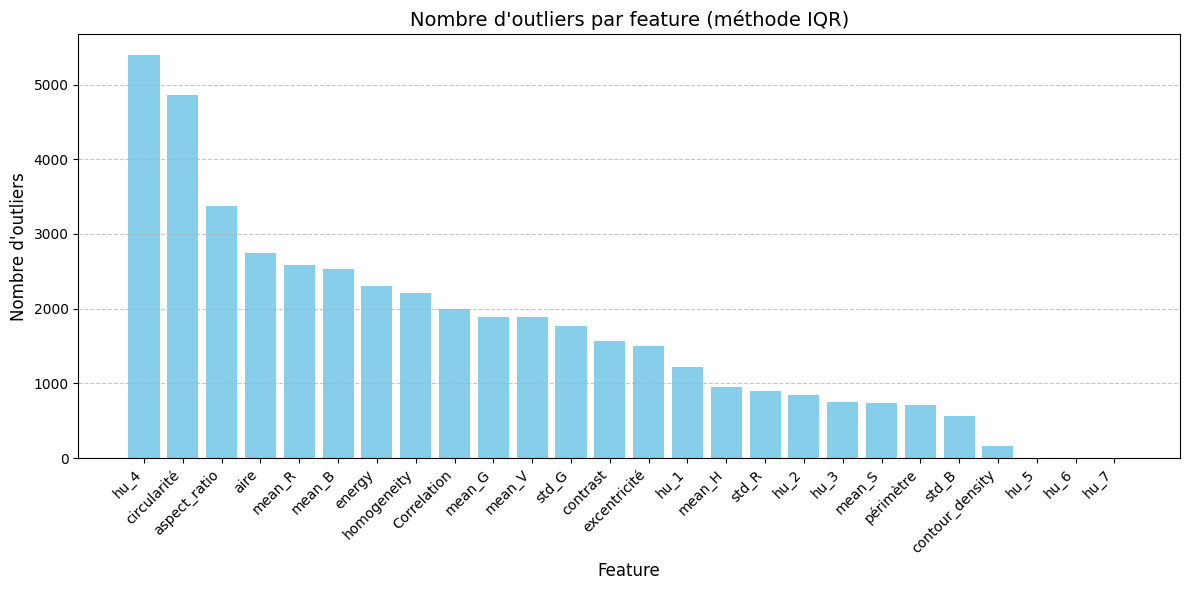

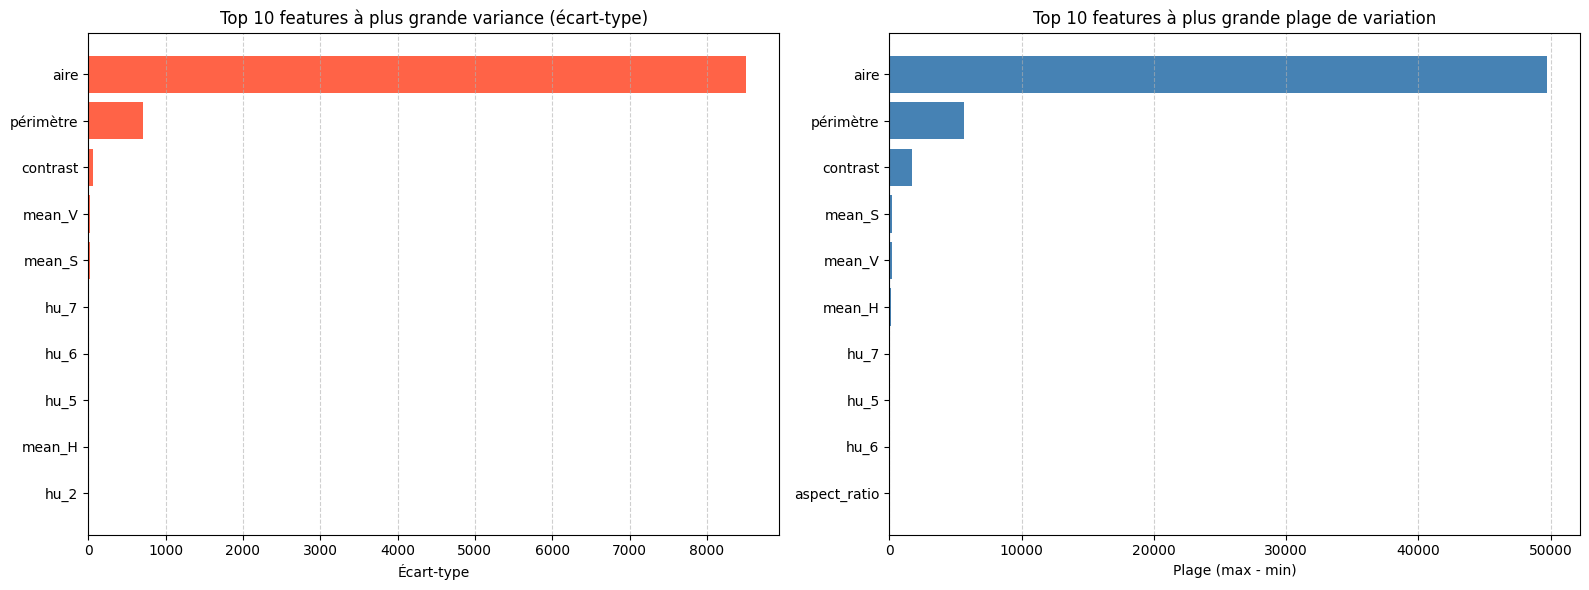

In [5]:
# Appel de la fonction d'analyse statistique des features

# Sélection automatique des colonnes de features numériques
colonnes_features = [col for col in df.columns if any(prefix in col for prefix in ['mean_', 'std_', 'aspect_', 'aire', 'périmètre', 'circularité', 'excentricité', 'contrast', 'hu_', 'contour_', 'energy', 'homogeneity', 'Correlation'])]

# Analyse descriptive
desc_df, outliers_df = stats_par_feature(df, colonnes_features)

# Outliers - Trie des features par nombre d’outliers décroissant et graphique
outliers_sorted = outliers_df.sort_values(by="Nb_outliers", ascending=False)
plt.figure(figsize=(12, 6))
plt.bar(outliers_sorted.index, outliers_sorted["Nb_outliers"], color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.title("Nombre d'outliers par feature (méthode IQR)", fontsize=14)
plt.ylabel("Nombre d'outliers", fontsize=12)
plt.xlabel("Feature", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# statistiques descriptives
# Calcul de la plage (range)  
if "range" not in desc_df.columns:
    desc_df["range"] = desc_df["max"] - desc_df["min"]

# Extraire les séries nécessaires
std_series = desc_df["std"]
range_series = desc_df["range"]

# Sélectionner les 10 features à plus forte variation
top_std = std_series.sort_values(ascending=False).head(10)
top_range = range_series.sort_values(ascending=False).head(10)

# Tracer les deux graphiques côte à côte
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Écart-type
axes[0].barh(top_std.index[::-1], top_std.values[::-1], color='tomato')
axes[0].set_title("Top 10 features à plus grande variance (écart-type)")
axes[0].set_xlabel("Écart-type")
axes[0].grid(axis='x', linestyle='--', alpha=0.6)

# Plage (max - min)
axes[1].barh(top_range.index[::-1], top_range.values[::-1], color='steelblue')
axes[1].set_title("Top 10 features à plus grande plage de variation")
axes[1].set_xlabel("Plage (max - min)")
axes[1].grid(axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

                 outliers_saines  outliers_malades  pct_saines  pct_malades
feature                                                                    
aire                         872              1879    0.057875     0.047934
périmètre                    199               508    0.013208     0.012959
circularité                  875              3990    0.058074     0.101786
excentricité                 497              1007    0.032986     0.025689
aspect_ratio                 686              2687    0.045530     0.068546
mean_R                      1033              1547    0.068560     0.039464
mean_G                      1107               786    0.073472     0.020051
mean_B                      1123              1407    0.074534     0.035893
std_R                         11               888    0.000730     0.022653
std_G                        904               859    0.059999     0.021913
std_B                        183               383    0.012146     0.009770
contrast    

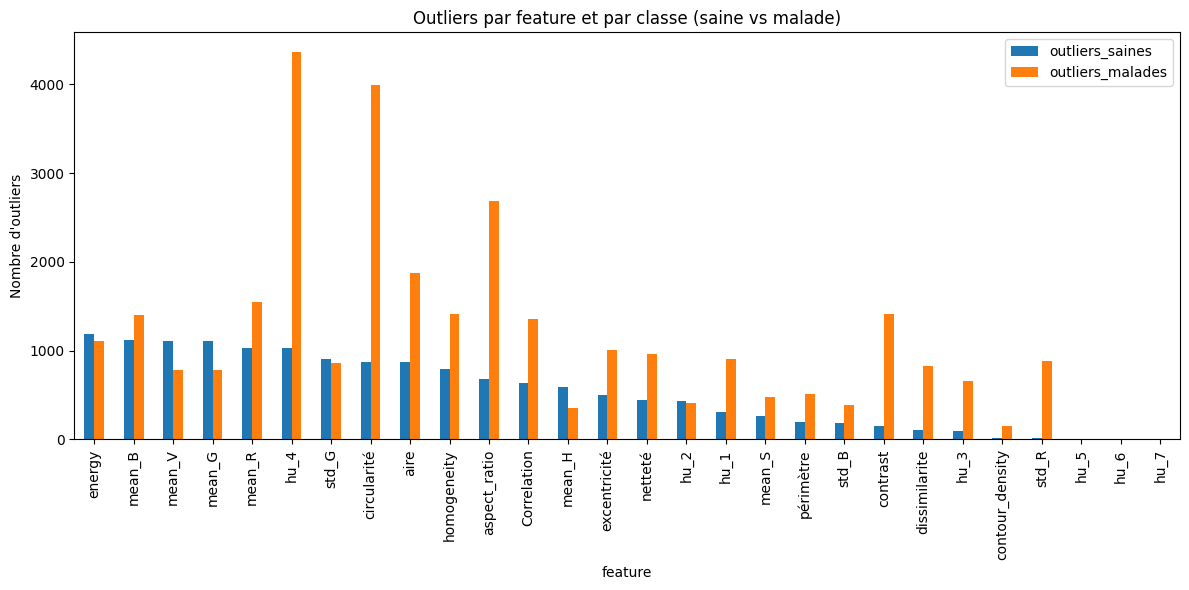

In [6]:
# 1. Définir les colonnes à analyser (toutes les colonnes numériques sauf ID, Est_Saine, is_black, dimensions, et les one-hot plant_/disease_)
exclude = {'ID_Image', 'Est_Saine', 'is_black', 'dimensions'}
features = [
    col for col in df.columns
    if col not in exclude
    and not col.startswith(('plant_', 'disease_'))
]

# 2. Calculer et flagger les outliers IQR pour chaque feature
for col in features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    df[f'{col}_outlier'] = ((df[col] < lower) | (df[col] > upper)).astype(int)

# 3. Agréger par classe (Est_Saine = 1 → saine, 0 → malade)
summary = []
for col in features:
    ocol = f'{col}_outlier'
    grp = df.groupby('Est_Saine')[ocol].agg(['sum', 'mean']).rename(
        index={0: 'malade', 1: 'saine'}
    )
    summary.append({
        'feature': col,
        'outliers_saines': int(grp.loc['saine', 'sum']),
        'outliers_malades': int(grp.loc['malade', 'sum']),
        'pct_saines': grp.loc['saine', 'mean'],
        'pct_malades': grp.loc['malade', 'mean']
    })

outlier_df = pd.DataFrame(summary).set_index('feature')
print(outlier_df)

# 4. (Optionnel) Visualiser la distribution des outliers par classe
outlier_df[['outliers_saines', 'outliers_malades']]\
    .sort_values('outliers_saines', ascending=False)\
    .plot(kind='bar', figsize=(12,6))
plt.ylabel("Nombre d'outliers")
plt.title("Outliers par feature et par classe (saine vs malade)")
plt.tight_layout()